In [8]:
import json
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
)
import matplotlib.pyplot as plt
from src.ergochemics.draw import draw_molecule, draw_reaction
from src.ergochemics.mapping import rc_to_nest
from IPython.display import SVG
from ast import literal_eval
from collections import Counter
from ast import literal_eval
from pathlib import Path


In [9]:
def quick_roc(df: pd.DataFrame) -> float:
    score = roc_auc_score(df['y'], df['logits'])
    return score

In [10]:
clip_random = pd.read_csv('/home/stef/clipzyme/files/time_split_random_target_output.csv')
clip_random_af2_add = pd.read_csv('/home/stef/clipzyme/files/time_split_random_af2_add_target_output.csv')
clip_random = pd.concat([clip_random, clip_random_af2_add], axis=0)
clip_arc = pd.read_csv('/home/stef/clipzyme/files/time_split_arc_target_output.csv')
clip_random['enzyme_scores'] = clip_random['enzyme_scores'].apply(lambda x: literal_eval(x)[0])
clip_arc['enzyme_scores'] = clip_arc['enzyme_scores'].apply(lambda x: literal_eval(x)[0])
clip_random.head()

,reaction,sequence,protein_id,y,cif,enzyme_scores
0,[*:1][NH:2][C@@H:3]([CH2:4][O:5][P:32](=[O:33]...,MFNVSNNVAPSRYQGPSSTSVTPNAFHDVPSLGQKVGAGSQKDVFH...,A0A085GHR3,1,/projects/p30041/spn1560/hiec/data/time_split/...,0.149470
1,[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8]...,MSSLLDIIYQLRQVPRWDGSFQFEKEDVSQHSFSVIAISHILCELK...,O24769,1,/projects/p30041/spn1560/hiec/data/time_split/...,0.001220
2,[CH3:1][O:45][c:44]1[cH:43][cH:42][c:41](/[CH:...,MYESIIPFPDETASTVDKYCCSHSTSLPPLFADHAAWTVDKFQTSY...,A0A397HK53,1,/projects/p30041/spn1560/hiec/data/time_split/...,0.304448
3,[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][CH2:6]/[C:...,MCKMYKVVETDASPGQRSVLQLVKDLLILSRFHKYNPWLAVFSGGV...,Q4WBI5,1,/projects/p30041/spn1560/hiec/data/time_split/...,0.441086
4,[NH2:1][C:2](=[O:3])[C:4]1=[CH:48][N:8]([C@@H:...,MNEILKKRLKLLKNNFGTHINKIANKKILITGANGYIGSILTLILH...,A0A0U3AP28,1,/projects/p30041/spn1560/hiec/data/time_split/...,0.198381


In [11]:
clip_rand_score = roc_auc_score(clip_random['y'], clip_random['enzyme_scores'])
clip_arc_score = roc_auc_score(clip_arc['y'], clip_arc['enzyme_scores'])
clip_prc = precision_recall_curve(clip_random['y'], clip_random['enzyme_scores'])
clip_rand_auprc = np.trapezoid(clip_prc[1], clip_prc[0])
clip_param_ct = 226e6


In [12]:
rz_random = pd.read_parquet("/home/stef/ReactZyme/results/25_time_split/esm_unimol_nm_10_epoch271target_output.parquet")
rz_random_clip_filtered = rz_random[rz_random['sequence'].isin(clip_random['sequence'])]
rz_auroc = roc_auc_score(rz_random['true_label'], rz_random['score'])
rz_prc = precision_recall_curve(rz_random['true_label'], rz_random['score'])
rz_auprc = np.trapezoid(rz_prc[1], rz_prc[0])
rz_auroc_clip_filtered = roc_auc_score(rz_random_clip_filtered['true_label'], rz_random_clip_filtered['score'])
rz_prc_clip_filtered = precision_recall_curve(rz_random_clip_filtered['true_label'], rz_random_clip_filtered['score'])
rz_auprc_clip_filtered = np.trapezoid(rz_prc_clip_filtered[1], rz_prc_clip_filtered[0])
rz_param_ct = 1344278
rz_random.head()

,molecule,sequence,true_label,score
0,CC1=C(CO)[C@@]2(C)CCCC(C)(C)[C@@H]2CC1.O=P(O)(...,MCTTFKAAIFDMGGVLFTWNPIVDTQVSLKDLGTIINSETWEQFER...,1.0,0.691342
1,CN[C@@H](COP(=O)(O)O)C(C)=O.Nc1ncnc2c1ncn2[C@@...,MFNVSNNVAPSRYQGPSSTSVTPNAFHDVPSLGQKVGAGSQKDVFH...,1.0,0.004624
2,Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@H]1CO.O=P(O)...,MSSLLDIIYQLRQVPRWDGSFQFEKEDVSQHSFSVIAISHILCELK...,1.0,0.000000
3,COc1ccc(/C=C2\NC(=O)[C@H](CCCNC(=N)N)NC2=O)cc1...,MYESIIPFPDETASTVDKYCCSHSTSLPPLFADHAAWTVDKFQTSY...,1.0,0.000002
4,CC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C(C)=C/Cc1c(O)cc...,MCKMYKVVETDASPGQRSVLQLVKDLLILSRFHKYNPWLAVFSGGV...,1.0,0.157656


In [13]:
final_clip_whitelist = clip_random['protein_id'].unique().tolist()
_final_clip_whitelist = clip_arc['protein_id'].unique().tolist()
# assert set(final_clip_whitelist) == set(_final_clip_whitelist)

In [14]:
# ***
# Trained on rcmcs split, which is better stratified, and has random negs. Test neg samples are random
run_ids = {
    "rc_cxn": "722de30540f6401d8d7fd12e8c2d0b4a",
    "rc_agg": "1fbaa827a8384e8da2fadaaa945fce13",
    "bom": "2fcb812a06c841d282d378d9f99e64c9",
    "cgr": "4c7872263bba4bd2952057c3146c7c9f",
    "mfp": "baa4374b85ca4deaa6df54cdc14617b7",
    "rxnfp": "2ae3adca4b534b6cb25872db6788bbad",
    "drfp": "cef83964c0cb429aa6724da42fd4cb7b",

}
res_file = "time_split_random_target_output.parquet"
ct_file = "n_trainable_params.txt"
dirs = {
    k: Path(f"/home/stef/quest_data/hiec/results/predictions/{run_id}")
    for k, run_id in run_ids.items()

}
for k, _dir in dirs.items():
    df = pd.read_parquet(_dir / res_file)
    df_clip_filtered = df[df['pid'].isin(final_clip_whitelist)]
    score = quick_roc(df)
    score_clip_filtered = quick_roc(df_clip_filtered)
    prc_curve = precision_recall_curve(df['y'], df['logits'])
    prc_curve_clip_filtered = precision_recall_curve(df_clip_filtered['y'], df_clip_filtered['logits'])
    auprc = np.trapezoid(prc_curve[1], prc_curve[0])
    auprc_clip_filtered = np.trapezoid(prc_curve_clip_filtered[1], prc_curve_clip_filtered[0])
    print(f"{k}:\n {score:.3f} (clip filtered: {score_clip_filtered:.3f})")
    print(f" AUPRC: {auprc:.3f} (clip filtered: {auprc_clip_filtered:.3f})")

    with open(_dir / ct_file, 'r') as f:
        total_params = int(f.read().strip())
    print(f" Total model params: {total_params:.1e}")
    print("-" * 100)

print(f"\nReactZyme ESM-Unimol:\n {rz_auroc:.3f} (clip filtered: {rz_auroc_clip_filtered:.3f})")
print(f" AUPRC: {rz_auprc:.3f} (clip filtered: {rz_auprc_clip_filtered:.3f})")
print(f" Total model params: {rz_param_ct:.1e}")
print("-" * 100)


print(f"ClipZyme:\n {clip_rand_score:.3f}")
print(f" AUPRC: {clip_rand_auprc:.3f}")
print(f" Total model params: {clip_param_ct:.1e}")
print("-" * 100)
print(f"\nClipZyme cannot predict {len(set(df['pid']) - set(final_clip_whitelist))} out of {len(set(df['pid']))} test proteins.")

rc_cxn:
 0.887 (clip filtered: 0.905)
 AUPRC: 0.483 (clip filtered: 0.524)
 Total model params: 7.3e+04
----------------------------------------------------------------------------------------------------
rc_agg:
 0.815 (clip filtered: 0.825)
 AUPRC: 0.402 (clip filtered: 0.425)
 Total model params: 2.5e+05
----------------------------------------------------------------------------------------------------
bom:
 0.889 (clip filtered: 0.888)
 AUPRC: 0.460 (clip filtered: 0.465)
 Total model params: 3.5e+04
----------------------------------------------------------------------------------------------------
cgr:
 0.816 (clip filtered: 0.848)
 AUPRC: 0.408 (clip filtered: 0.446)
 Total model params: 5.7e+05
----------------------------------------------------------------------------------------------------
mfp:
 0.754 (clip filtered: 0.806)
 AUPRC: 0.297 (clip filtered: 0.313)
 Total model params: 2.0e+05
-------------------------------------------------------------------------------------

In [17]:
run_ids = {
    "rc_cxn": "99fb3dad48464fd8a2af365b5fd57621",
    "rc_agg": "9226ba678bcd42fbb95b44979deeabff",
    "bom": "fafcf359d8864d1a8d012d65eb4f350d",
    "cgr": "25964e2b2fcb4ee1aa6f5487866209bd",
    "mfp": "b736cf547f5b46a0b8eb0308bddcabbd",
    "drfp": "636aa60f113244c5af41fa0573b6e814",
}
res_file = "time_split_alternate_reaction_center_target_output.parquet"
ct_file = "n_trainable_params.txt"
dirs = {
    k: Path(f"/home/stef/quest_data/hiec/results/predictions/{run_id}")
    for k, run_id in run_ids.items()

}
for k, _dir in dirs.items():
    df = pd.read_parquet(_dir / res_file)
    score = quick_roc(df)
    print(f"{k}:\n {score:.3f}")

    with open(_dir / ct_file, 'r') as f:
        total_params = int(f.read().strip())
    print(f" Total model params: {total_params:.1e}")
    print("-" * 100)


rc_cxn:
 0.786
 Total model params: 7.3e+04
----------------------------------------------------------------------------------------------------
rc_agg:
 0.770
 Total model params: 2.5e+05
----------------------------------------------------------------------------------------------------
bom:
 0.850
 Total model params: 3.5e+04
----------------------------------------------------------------------------------------------------
cgr:
 0.834
 Total model params: 5.7e+05
----------------------------------------------------------------------------------------------------
mfp:
 0.865
 Total model params: 2.0e+05
----------------------------------------------------------------------------------------------------
drfp:
 0.890
 Total model params: 8.6e+04
----------------------------------------------------------------------------------------------------


In [18]:
new_rxns = pd.read_csv("/home/stef/quest_data/hiec/data/time_split/250915_sprhea_time_split_raw.tsv", sep="\t")
new_rxns.head()

,id,sequence,existence,reviewed,ec,organism,name,subunit,rxn_id,reverse,...,rhea_idx,smarts,am_smarts,rule,template_aidxs,rule_id,rev_rxn_id,rev_rule_id,am_chiral_smarts,chiral_smarts
0,Q8IV08,MKPKLMYQELKVPAEEPANELPMNEIEAWKAAEKKARWVLLVLILA...,Evidence at protein level,reviewed,3.1.16.1; 3.1.4.-,Homo sapiens (Human),"5'-3' exonuclease PLD3 (EC 3.1.16.1) ((S,S)-bi...",False,5726b29f0352fc541d31599b36ffdc753d58a4a8,*OC1CC(*)OC1COP(=O)(O)OC1CC(*)OC1CO.O>>*C1CC(O...,...,17140,*OC1CC(*)OC1CO.*C1CC(OP(=O)(O)O)C(CO)O1>>*OC1C...,[*:10][O:7][CH:5]1[CH2:8][CH:6]([*:9])[O:4][CH...,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],"8,9;7>>8,9;0",517,bcca4cd80a017ffdbe5142623d7fb6a648ed052f,517,[*:1][O:2][C@H:3]1[CH2:4][C@H:5]([*:6])[O:7][C...,*O[C@H]1C[C@H](*)O[C@@H]1CO.*[C@H]1C[C@H](OP(=...
1,A0A397HK53,MYESIIPFPDETASTVDKYCCSHSTSLPPLFADHAAWTVDKFQTSY...,Evidence at protein level,reviewed,2.1.1.-,Aspergillus thermomutatus (Neosartorya pseudof...,O-methyltransferase ankF (EC 2.1.1.-) (Ank bio...,False,e083443eeced3a35861687bd0dbcf4f29a78e8db,C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)...,...,16887,Nc1ncnc2c1ncn2C1OC(CSCCC(N)C(=O)O)C(O)C1O.COc1...,[NH2:27][c:25]1[n:26][cH:24][n:22][c:20]2[c:23...,[#16:1].[#6:2]-[#8:3]>>[#6:2]-[#16+:1].[#8:3],"14;0,1>>0,1;17",796,7a9348243ae86b91ee69654cc9a4a0487464bcf0,563,[CH3:1][O:45][c:44]1[cH:43][cH:42][c:41](/[CH:...,COc1ccc(/C=C2\NC(=O)[C@H](CCCNC(=N)N)NC2=O)cc1...
2,A0A913XCT1,MPVGSRQNRVQAVRKVSGSTDSTIPREAGIYPIRYTERKERKDVQT...,Evidence at protein level,reviewed,2.7.7.86,Exaiptasia diaphana (Tropical sea anemone) (Ai...,Cyclic GMP-AMP synthase-like receptor (Ep-cGLR...,False,bf6dcf54694621f607903190796e2dd737021fc6,Nc1nc2c(ncn2C2OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O...,...,3323,O=P(O)(O)OP(=O)(O)O.Nc1nc2c(ncn2C2OC3COP(=O)(O...,[O:5]=[P:4]([OH:2])([OH:6])[O:7][P:8](=[O:9])(...,[#8:1].[#8:2]-[#15:3]>>([#8:2].[#8:1]-[#15:3]),"2;16,13>>13,16,50",873,283b56473580903927f29c481f53139e636b287d,603,[NH2:1][c:2]1[n:3][c:4]2[c:5]([n:6][cH:7][n:8]...,Nc1nc2c(ncn2[C@@H]2O[C@@H]3COP(=O)(O)O[C@H]4[C...
3,A6QLJ8,MSSLSGKVQTVLGLVEPGTLGRTLTHEHLTMTFDCCYYPPPPSHEA...,Evidence at transcript level,reviewed,3.1.-.-,Bos taurus (Bovine),N-acetyltaurine hydrolase (EC 3.1.-.-) (Phosph...,False,ae3278fb6ce30645bc3a098c1d04d6451434ff72,CCC(C)C(NC(C)=O)C(=O)O.O>>CC(=O)O.CCC(C)C(N)C(...,...,17078,CC(=O)O.CCC(C)C(N)C(=O)O>>CCC(C)C(NC(C)=O)C(=O...,[CH3:3][C:1](=[O:4])[OH:13].[CH3:12][CH2:8][CH...,[#6:1]-[#8:2].[#7:3]>>[#6:1]-[#7:3].[#8:2],"1,3;5>>5,6;0",175,e3ccaccd49982cfa35d717f4a71b4a7d911b09a7,587,[C:7]([CH3:8])(=[O:9])[OH:13].[CH3:1][CH2:2][C...,CC[C@H](C)[C@@H](N)C(=O)O.CC(=O)O>>CC[C@H](C)[...
4,Q0HWI9,MNLATNRALLKPFTQAEFPTLEAAAHPHIPAHLMPEYWQAANRHLV...,Evidence at protein level,reviewed,6.3.2.63,Shewanella sp. (strain MR-7),Putrebactin synthase (EC 6.3.2.63) (Putrebacti...,False,d246c3fe088014817e2b7b51b22c55b558dbead4,NCCCCN(O)C(=O)CCC(=O)NCCCCN(O)C(=O)CCC(=O)O.Nc...,...,16664,NCCCCN(O)C(=O)CCC(=O)O.NCCCCN(O)C(=O)CCC(=O)O....,[NH2:14][CH2:13][CH2:12][CH2:11][CH2:9][N:7]([...,[#6:1]-[#8:2].[#7:3].[#8:4]-[#15:5]>>[#6:1]-[#...,"11,13;0;18,15>>11,13;2;15,17",471,00e5d91715ebef44b8ac0e8e26173036c9e47b3d,427,[NH:1]([CH2:2][CH2:3][CH2:4][CH2:5][N:6]([OH:7...,NCCCCN(O)C(=O)CCC(=O)NCCCCN(O)C(=O)CCC(=O)O.Nc...


In [19]:
i = 6

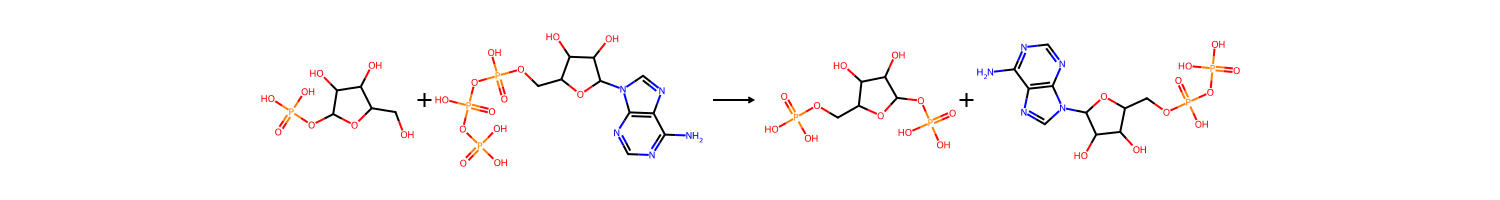

Reactants:


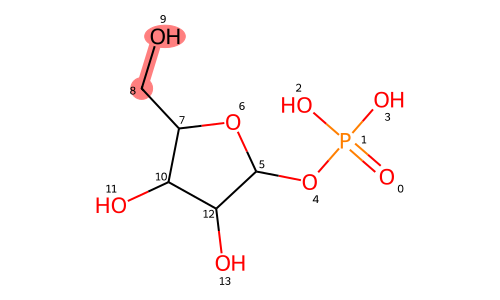

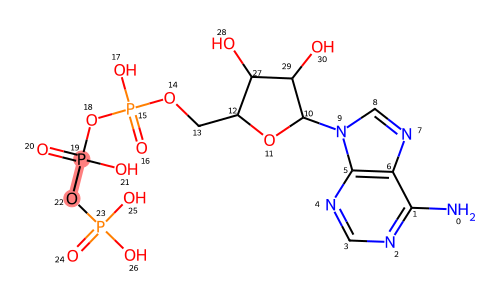

Products:


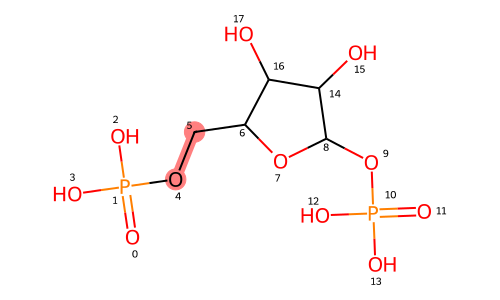

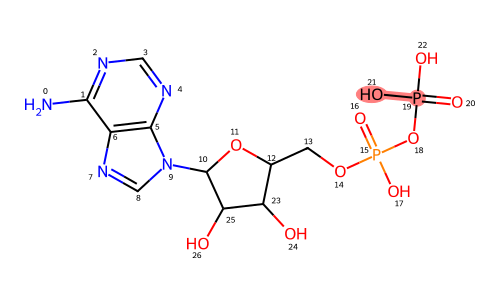

In [20]:
i += 1
smarts = new_rxns.loc[i, 'smarts']
rcs = rc_to_nest(new_rxns.loc[i, 'template_aidxs'])
display(SVG(draw_reaction(smarts)))
rcts, pdts = [side.split(".") for side in smarts.split(">>")]

print("Reactants:")
for rct, rc in zip(rcts, rcs[0]):
    display(SVG(draw_molecule(rct, highlight_atoms=[aidx for aidx in rc], draw_options={'addAtomIndices': True}, size=(500, 300))))

print("Products:")
for pdt, rc in zip(pdts, rcs[1]):
    display(SVG(draw_molecule(pdt, highlight_atoms=[aidx for aidx in rc], draw_options={'addAtomIndices': True}, size=(500, 300))))

In [21]:
with open(Path("/home/stef/quest_data/hiec/data") / "sprhea" / "v3_folded_pt_ns.json", 'r') as f:
    rxns_24 = json.load(f)

In [22]:
rules = pd.read_csv("/home/stef/hiec/artifacts/rc_plus_0_rules.csv", sep=",")
rules['ni_ids'] = rules['ni_ids'].apply(literal_eval)
new_to_old = {}
for _, row in rules.iterrows():
    for elt in row['ni_ids']:
        new_to_old[row['id']] = elt

In [23]:
old_rules = []
for elt in rxns_24.values():
    old_rules.extend(elt['min_rules'])

old_rule_cts = Counter(old_rules)
old_rules = set(old_rules)

In [24]:
new_rules = list()
for _, row in new_rxns.iterrows():
    new_rules.append(new_to_old.get(row['rule_id'], None))
    new_rules.append(new_to_old.get(row['rev_rule_id']))

new_rule_cts = Counter(new_rules)
new_rules = set(new_rules)
new_rules.discard(None)

In [25]:
print(f"Number of new rules: {len(new_rules)}")
print(f"Number of old rules: {len(old_rules)}")
print(f"Number of overlapping rules: {len(new_rules.intersection(old_rules))}")

Number of new rules: 113
Number of old rules: 748
Number of overlapping rules: 100


In [26]:
srt_new_rules = sorted(new_rule_cts.items(), key=lambda x: x[1], reverse=True)
srt_old_rules = sorted(old_rule_cts.items(), key=lambda x: x[1], reverse=True)
k = 10
for new, old in zip(srt_new_rules[:k], srt_old_rules[:k]):
    print(f"New rule: {new}, Old rule: {old}")

New rule: ('rule0105', 214), Old rule: ('rule0001', 824)
New rule: ('rule0517', 182), Old rule: ('rule0007', 463)
New rule: ('rule0847', 54), Old rule: ('rule0006', 463)
New rule: ('rule0846', 54), Old rule: ('rule0002', 443)
New rule: ('rule0429', 39), Old rule: ('rule0003', 442)
New rule: ('rule0430', 39), Old rule: ('rule0021', 384)
New rule: ('rule1222', 28), Old rule: ('rule0022', 384)
New rule: ('rule0394', 26), Old rule: ('rule0014', 231)
New rule: ('rule0393', 26), Old rule: ('rule0015', 231)
New rule: ('rule0284', 24), Old rule: ('rule0012', 220)


In [27]:
for new in srt_new_rules[:k]:
    print(f"Rule: {new} occurs {new_rule_cts[new[0]]} times vs old rule occurs {old_rule_cts[new[0]]} times")

Rule: ('rule0105', 214) occurs 214 times vs old rule occurs 7 times
Rule: ('rule0517', 182) occurs 182 times vs old rule occurs 2 times
Rule: ('rule0847', 54) occurs 54 times vs old rule occurs 24 times
Rule: ('rule0846', 54) occurs 54 times vs old rule occurs 24 times
Rule: ('rule0429', 39) occurs 39 times vs old rule occurs 5 times
Rule: ('rule0430', 39) occurs 39 times vs old rule occurs 5 times
Rule: ('rule1222', 28) occurs 28 times vs old rule occurs 1 times
Rule: ('rule0394', 26) occurs 26 times vs old rule occurs 34 times
Rule: ('rule0393', 26) occurs 26 times vs old rule occurs 34 times
Rule: ('rule0284', 24) occurs 24 times vs old rule occurs 16 times


In [28]:
for old in srt_old_rules[:k]:
    print(f"Rule: {old} occurs {old_rule_cts[old[0]]} times vs new rule occurs {new_rule_cts[old[0]]} times")

Rule: ('rule0001', 824) occurs 824 times vs new rule occurs 0 times
Rule: ('rule0007', 463) occurs 463 times vs new rule occurs 0 times
Rule: ('rule0006', 463) occurs 463 times vs new rule occurs 0 times
Rule: ('rule0002', 443) occurs 443 times vs new rule occurs 9 times
Rule: ('rule0003', 442) occurs 442 times vs new rule occurs 9 times
Rule: ('rule0021', 384) occurs 384 times vs new rule occurs 0 times
Rule: ('rule0022', 384) occurs 384 times vs new rule occurs 0 times
Rule: ('rule0014', 231) occurs 231 times vs new rule occurs 0 times
Rule: ('rule0015', 231) occurs 231 times vs new rule occurs 0 times
Rule: ('rule0012', 220) occurs 220 times vs new rule occurs 0 times


In [29]:
k = np.argwhere((np.cumsum([np.array([x[1] for x in srt_new_rules])]) / sum([x[1] for x in srt_new_rules])) > 0.8)[0][0]

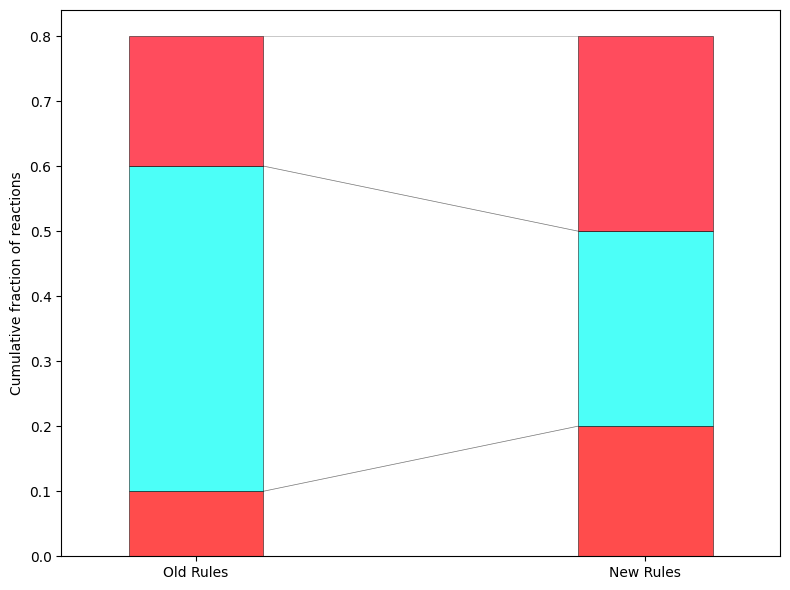

In [30]:
def plot_stacked_bars_with_connections(x, y, x_label='X', y_label='Y', figsize=(10, 8)):
    """
    Plot two stacked vertical bars with connecting lines between corresponding segments.
    
    Parameters:
    x: list of float values for left bar
    y: list of float values for right bar
    x_label: label for left bar
    y_label: label for right bar
    figsize: figure size tuple
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Positions for the two bars
    bar_positions = [0, 1]
    bar_width = 0.3
    
    # Calculate cumulative positions for stacking
    x_cumsum = np.concatenate([[0], np.cumsum(x)])
    y_cumsum = np.concatenate([[0], np.cumsum(y)])
    
    # Create a colormap
    colors = plt.cm.hsv(np.linspace(0, 1, len(x)))
    np.random.shuffle(colors)
    
    # Draw stacked bars
    for i in range(len(x)):
        # Left bar
        ax.bar(bar_positions[0], x[i], bar_width, bottom=x_cumsum[i], 
               color=colors[i], alpha=0.7, edgecolor='black', linewidth=0.5)
        # Right bar
        ax.bar(bar_positions[1], y[i], bar_width, bottom=y_cumsum[i], 
               color=colors[i], alpha=0.7, edgecolor='black', linewidth=0.5)
        
        # Draw connecting lines
        # Bottom line
        ax.plot([bar_positions[0] + bar_width/2, bar_positions[1] - bar_width/2],
                [x_cumsum[i], y_cumsum[i]], 
                'k-', alpha=0.3, linewidth=0.5)
        # Top line
        ax.plot([bar_positions[0] + bar_width/2, bar_positions[1] - bar_width/2],
                [x_cumsum[i+1], y_cumsum[i+1]], 
                'k-', alpha=0.3, linewidth=0.5)
    
    # Set labels and formatting
    ax.set_xticks(bar_positions)
    ax.set_xticklabels([x_label, y_label])
    ax.set_ylabel('Cumulative fraction of reactions')
    ax.set_xlim(-0.3, 1.3)
    
    plt.tight_layout()
    return fig, ax

x = [0.1, 0.5, 0.2]
y = [0.2, 0.3, 0.3]
fig, ax = plot_stacked_bars_with_connections(x, y, x_label='Old Rules', y_label='New Rules', figsize=(8, 6))
plt.show()

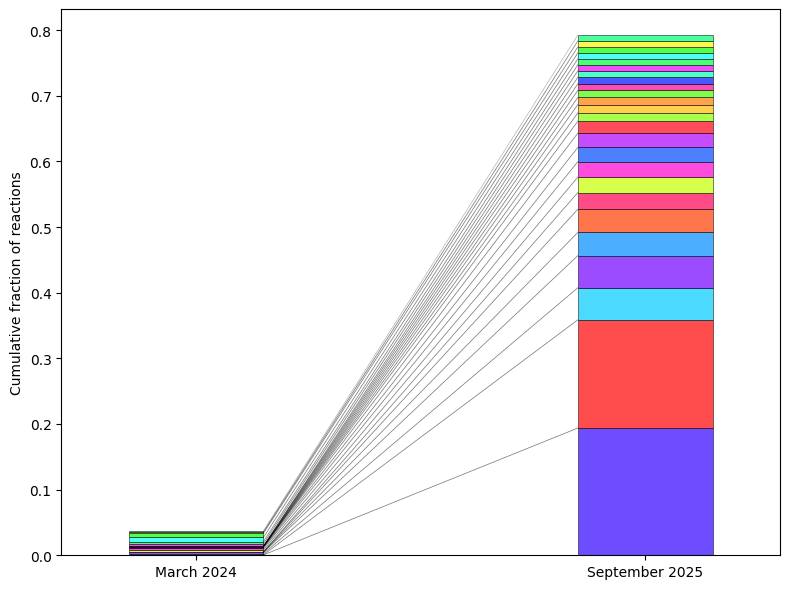

In [31]:
tot_old_rxns = sum(old_rule_cts.values())
tot_new_rxns = sum(new_rule_cts.values())
k = np.argwhere((np.cumsum([np.array([x[1] for x in srt_new_rules])]) / sum([x[1] for x in srt_new_rules])) > 0.8)[0][0]
x = [old_rule_cts[srt_new_rules[i][0]] / tot_old_rxns for i in range(k)]
y = [new_rule_cts[srt_new_rules[i][0]] / tot_new_rxns for i in range(k)]
fig, ax = plot_stacked_bars_with_connections(x, y, x_label='March 2024', y_label='September 2025', figsize=(8, 6))
plt.tight_layout()
fig.savefig("/home/stef/hiec/artifacts/figures/methods/compare_rule_usage_time_split_sprhea.svg")
plt.show()